## Outcome prediction after Chikungunya hospitalization

#### MC853 - Unicamp

- Leandro Henrique Silva Resende – 213437 

- Pietro Grazzioli Golfeto – 223694 

- Yvens Ian Prado Porto – 184031 

In [1]:
# Required Libraries
# We used Python 3.10.12

# Define random state for reproducibility
random_state = 42

# Data manipulation
import pandas as pd
import os # Operating system dependent functionalities (like path manipulation)
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import time # For timing operations
from IPython.display import display # Rich DataFrame output in Jupyter environments

# Imbalanced-learn library for handling imbalanced datasets
from imblearn.over_sampling import SMOTE # Synthetic Minority Over-sampling Technique
from imblearn.under_sampling import RandomUnderSampler # Randomly under-sample majority class
from imblearn.pipeline import Pipeline as ImblearnPipeline # Pipeline for imblearn transformations (aliased to avoid conflict with sklearn.pipeline if used)

# Scikit-learn for preprocessing, modeling, and evaluation
from sklearn.preprocessing import RobustScaler # Scaler robust to outliers
from sklearn.impute import KNNImputer # Imputation for completing missing values using k-Nearest Neighbors
from sklearn.model_selection import StratifiedKFold # Cross-validator for stratified sampling
from sklearn.linear_model import LogisticRegression # Logistic Regression model
from sklearn.ensemble import RandomForestClassifier # Random Forest model
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors model
from sklearn.model_selection import GridSearchCV # For hyperparameter tuning using grid search
from sklearn.metrics import ConfusionMatrixDisplay # For visualizing confusion matrices

# Scikit-learn metrics for model evaluation
from sklearn.metrics import (
    make_scorer, recall_score, precision_score, fbeta_score, # Scorers for classification
    f1_score, balanced_accuracy_score, roc_auc_score, # Common classification metrics
    average_precision_score # Metric for precision-recall curve
)

# Warnings management
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning) # Suppress DataConversionWarning for cleaner output

In [2]:
# Paths to the data (change according to your system)
# Defines dictionaries containing paths to the dataset files for different users.
# This allows the script to be portable between different machine setups.

leandro_path = {
    'X_train_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/X_train.csv',
    'y_train_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/y_train.csv',
    'X_test_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/X_test.csv',
    'y_test_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/y_test.csv',
}

pietro_path = {
    'X_train_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/X_train.csv',
    'y_train_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/y_train.csv',
    'X_test_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/X_test.csv',
    'y_test_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/y_test.csv',
}

In [ ]:
# Set the path based on the user
# Checks for the existence of the dataset files based on the defined paths
# and selects the appropriate path configuration.
if os.path.isfile(pietro_path['X_train_path']):
    path_config = pietro_path # Use Pietro's path configuration
elif os.path.isfile(leandro_path['X_train_path']):
    path_config = leandro_path # Use Leandro's path configuration
else:
    # If neither path configuration is valid, raise an exception.
    raise Exception('Path not found. Please check the paths in the script.')

# Get CSV files path using the selected configuration
# os.path.expanduser expands '~' to the user's home directory.
X_train_path = os.path.expanduser(path_config['X_train_path'])
y_train_path = os.path.expanduser(path_config['y_train_path'])
X_test_path = os.path.expanduser(path_config['X_test_path'])
y_test_path = os.path.expanduser(path_config['y_test_path'])

# Get the directory of the datasets for saving processed files.
# This will be used to save the preprocessed and resampled datasets in the same location.
base_output_dir = os.path.dirname(X_train_path)

In [4]:
# Load the datasets from CSV files into pandas DataFrames and Series.
# `low_memory=False` can prevent type inference issues for columns with mixed types.
X_train = pd.read_csv(X_train_path, low_memory=False) # Load training features
y_train = pd.read_csv(y_train_path, low_memory=False).squeeze("columns") # Load training labels and convert to Series
X_test = pd.read_csv(X_test_path, low_memory=False)  # Load test features
y_test = pd.read_csv(y_test_path, low_memory=False).squeeze("columns")   # Load test labels and convert to Series

In [5]:
# Display the first few rows of the training feature set for a quick inspection.
X_train.head()

,AGE,GENDER,PREGNANT,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,...,REGION_MIDWEST,REGION_SOUTHEAST,REGION_SOUTH,TIME_DIFF_DAYS,TIME,WHITE,BLACK,YELLOW,BROWN,INDIGENOUS
0,10.0,0,0.0,1,1,1,1,0,1,1,...,0,0,0,1,26,0,0,0,1,0
1,29.0,1,0.0,1,1,1,1,0,1,1,...,0,0,0,5,25,0,0,0,1,0
2,11.0,1,0.0,1,1,1,0,0,0,0,...,0,0,0,2,37,0,0,0,1,0
3,5.0,1,0.0,1,0,1,0,0,1,0,...,0,0,0,31,38,0,0,0,1,0
4,11.0,1,0.0,1,1,1,0,0,0,0,...,0,0,0,3,32,0,0,0,1,0


In [6]:
# Display the column names of the training feature set.
X_train.columns

Index(['AGE', 'GENDER', 'PREGNANT', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA',
       'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA',
       'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES',
       'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT',
       'AUTO_IMUNE', 'CONFIRMED_CASE', 'CRITERIO', 'REGION_NORTH',
       'REGION_NORTHEAST', 'REGION_MIDWEST', 'REGION_SOUTHEAST',
       'REGION_SOUTH', 'TIME_DIFF_DAYS', 'TIME', 'WHITE', 'BLACK', 'YELLOW',
       'BROWN', 'INDIGENOUS'],
      dtype='object')

In [7]:
# Display the first few rows of selected continuous features for a quick inspection.
X_train[['AGE', 'TIME_DIFF_DAYS', 'TIME']].head()

,AGE,TIME_DIFF_DAYS,TIME
0,10.0,1,26
1,29.0,5,25
2,11.0,2,37
3,5.0,31,38
4,11.0,3,32


In [8]:
# Preprocessing: Drop the 'CRITERIO' column.
# This column was identified as not relevant for the model, possibly redundant or uninformative.
X_train['CRITERIO'].value_counts() # Display value counts of 'CRITERIO' before dropping (for verification)
X_train = X_train.drop(columns=['CRITERIO']) # Drop 'CRITERIO' from training set
X_test = X_test.drop(columns=['CRITERIO'])   # Drop 'CRITERIO' from test set

In [9]:
# Define a function for imputing missing values using KNNImputer.
def impute_missing(data_train: pd.DataFrame, data_test: pd.DataFrame, n_neighbors: int = 3) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Impute missing values using the K-nearest neighbors algorithm.
    The imputer is fitted on the training data and then used to transform both
    training and test data to prevent data leakage.

    Parameters:
        data_train (pd.DataFrame): Training DataFrame with potentially missing values.
        data_test (pd.DataFrame): Test DataFrame with potentially missing values.
        n_neighbors (int, optional): Number of neighbors to use for imputation. Defaults to 3.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: DataFrames (train_imputed, test_imputed) 
                                           with missing values imputed.
    """
    # Initialize KNNImputer with the specified number of neighbors.
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Fit the imputer on the training data and transform the training data.
    imputed_data_train_array = imputer.fit_transform(data_train)
    # Transform the test data using the imputer fitted on the training data.
    imputed_data_test_array = imputer.transform(data_test)

    # Convert the imputed NumPy arrays back to pandas DataFrames, preserving original columns and index.
    imputed_df_train = pd.DataFrame(imputed_data_train_array, columns=data_train.columns, index=data_train.index)
    imputed_df_test = pd.DataFrame(imputed_data_test_array, columns=data_test.columns, index=data_test.index)

    return imputed_df_train, imputed_df_test

In [10]:
# Impute missing values in the training and test sets using the defined KNN imputation function.
X_train, X_test = impute_missing(X_train, X_test, n_neighbors=3)

In [11]:
# Define a function to remove outliers based on a threshold for a specified column.
def remove_outliers(X: pd.DataFrame, y: pd.Series, col: str, thresh: float) -> tuple[pd.DataFrame, pd.Series]:
    """
    Keep only rows where the value in X[col] is less than or equal to `thresh`.
    Corresponding rows are also dropped from `y`. Indices are reset.

    Parameters:
        X (pd.DataFrame): Feature DataFrame.
        y (pd.Series): Target Series.
        col (str): The column in X to check for outliers.
        thresh (float): The threshold value. Rows with X[col] > thresh are removed.

    Returns:
        tuple[pd.DataFrame, pd.Series]: DataFrames X and y with outliers removed.
    """
    # Create a boolean mask for rows where the column value is within the threshold.
    keep_mask = X[col] <= thresh
    
    # Apply the mask to filter X and y.
    X_clean = X.loc[keep_mask].reset_index(drop=True) # drop=True prevents old index from becoming a column
    y_clean = y.loc[keep_mask].reset_index(drop=True)
    
    # Print the number of removed outliers.
    print(f"Removed {len(X) - len(X_clean)} outliers from column '{col}' where values were > {thresh}")
    return X_clean, y_clean

In [12]:
# Remove rows where 'TIME_DIFF_DAYS' > 45, as these are considered outliers.
# This is applied to both training and test sets independently.
print("Train set outlier removal:")
X_train, y_train = remove_outliers(X=X_train, y=y_train, col='TIME_DIFF_DAYS', thresh=45)

print("\nTest set outlier removal:")
X_test , y_test  = remove_outliers(X=X_test , y=y_test, col='TIME_DIFF_DAYS', thresh=45)

Train set outlier removal:
Removed 743 outliers from column 'TIME_DIFF_DAYS' where values were > 45

Test set outlier removal:
Removed 239 outliers from column 'TIME_DIFF_DAYS' where values were > 45


In [13]:
# Define the list of continuous columns to be scaled.
continuous_cols = ['AGE', 'TIME_DIFF_DAYS', 'TIME'] 

# Display descriptive statistics for selected continuous features before scaling.
# This helps to understand the distribution of these features prior to transformation.
X_train[continuous_cols].describe()

,AGE,TIME_DIFF_DAYS,TIME
count,20983.000000,20983.000000,20983.000000
mean,32.964829,8.174522,160.614974
std,23.838605,8.008934,102.798928
min,0.000000,0.000000,0.000000
25%,12.000000,3.000000,66.000000
50%,30.000000,6.000000,155.000000
75%,51.000000,10.000000,263.000000
max,119.000000,45.000000,313.000000


In [14]:
# Scale continuous numerical features using RobustScaler.
# RobustScaler is chosen for its robustness to outliers, as it uses statistics based on percentiles (IQR).
scaler = RobustScaler()

# Fit the scaler on the training data's continuous columns and transform them.
# It's crucial to fit the scaler ONLY on the training data to prevent data leakage.
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
# Apply the SAME fitted scaler to transform the test data's continuous columns.
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

In [15]:
# ### Save Preprocessed Data
# At this point, `X_train`, `y_train`, `X_test`, and `y_test` have undergone all common preprocessing:
# - Dropping irrelevant columns
# - KNN imputation for missing values
# - Outlier removal
# - Robust scaling of continuous features
# 
# These fully preprocessed datasets are now saved to disk. This allows the fairness analysis script
# to load them directly, skipping these preprocessing steps.

In [16]:
# Define full paths for saving the processed datasets.
# They will be saved in the same directory as the original datasets.
X_train_processed_path = os.path.join(base_output_dir, 'X_train_processed.csv')
y_train_processed_path = os.path.join(base_output_dir, 'y_train_processed.csv')
X_test_processed_path = os.path.join(base_output_dir, 'X_test_processed.csv')
y_test_processed_path = os.path.join(base_output_dir, 'y_test_processed.csv')

# Save the processed DataFrames and Series to CSV files.
# `index=False` prevents writing the DataFrame index as a column in the CSV.
X_train.to_csv(X_train_processed_path, index=False)
# For Series, `header=True` ensures the Series name (if it exists) is written as the column header.
y_train.to_csv(y_train_processed_path, index=False, header=True) 
X_test.to_csv(X_test_processed_path, index=False)
y_test.to_csv(y_test_processed_path, index=False, header=True)

# Print confirmation messages with the paths of the saved files.
print(f"Saved processed X_train to: {X_train_processed_path}")
print(f"Saved processed y_train to: {y_train_processed_path}")
print(f"Saved processed X_test to: {X_test_processed_path}")
print(f"Saved processed y_test to: {y_test_processed_path}")

Saved processed X_train to: /home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/X_train_processed.csv
Saved processed y_train to: /home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/y_train_processed.csv
Saved processed X_test to: /home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/X_test_processed.csv
Saved processed y_test to: /home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/y_test_processed.csv


In [17]:
# Display statistics for the scaled continuous features in the training set.
# This shows the effect of RobustScaler (e.g., median around 0, IQR scaled).
X_train[continuous_cols].describe()

,AGE,TIME_DIFF_DAYS,TIME
count,20983.000000,20983.000000,20983.000000
mean,0.076021,0.310646,0.028502
std,0.611246,1.144133,0.521822
min,-0.769231,-0.857143,-0.786802
25%,-0.461538,-0.428571,-0.451777
50%,0.000000,0.000000,0.000000
75%,0.538462,0.571429,0.548223
max,2.282051,5.571429,0.802030


In [18]:
# Check the distribution of the target variable in the training set.
# `value_counts(normalize=True)` shows the proportion of each class.
print(f"Train set target distribution: \n{y_train.value_counts(normalize=True)},\n")

# Check the distribution of the target variable in the test set.
print(f"Test set target distribution: \n{y_test.value_counts(normalize=True)}")

Train set target distribution: 
EVOLUCAO
0    0.928418
1    0.071582
Name: proportion, dtype: float64,

Test set target distribution: 
EVOLUCAO
0    0.924028
1    0.075972
Name: proportion, dtype: float64


In [19]:
# Define the resampling pipeline for handling class imbalance in the training data.
# This pipeline will first oversample the minority class using SMOTE,
# then undersample the majority class using RandomUnderSampler.
resample_pipe = ImblearnPipeline(steps=[ # Using aliased ImblearnPipeline
    # SMOTE: Upsample minority class to 40% of the majority class size.
    ('o', SMOTE(sampling_strategy=0.4, random_state=random_state)), 
    # RandomUnderSampler: Downsample majority class to have a 1:1 ratio with the (now larger) minority class.
    ('u', RandomUnderSampler(sampling_strategy=1.0, random_state=random_state)) 
])

In [20]:
# ### Apply Resampling Pipeline and Save Resampled Training Data
# The `resample_pipe` (SMOTE + RandomUnderSampler) is now applied to the preprocessed `X_train` and `y_train`.
# The resulting resampled training data (`X_train_resampled`, `y_train_resampled`) are saved.
# This allows the fairness analysis script to optionally load this directly if a pre-resampled dataset (based on all features) is desired.

In [21]:
# Apply the resampling pipeline to the (preprocessed) training data.
# X_train at this point is the version that has been imputed, outliers removed, and scaled.
X_train_resampled, y_train_resampled = resample_pipe.fit_resample(X_train, y_train)

# Define paths for saving the resampled training datasets.
X_train_resampled_path = os.path.join(base_output_dir, 'X_train_resampled.csv')
y_train_resampled_path = os.path.join(base_output_dir, 'y_train_resampled.csv')

# Save the resampled training DataFrames and Series to CSV files.
X_train_resampled.to_csv(X_train_resampled_path, index=False)
# `y_train_resampled` is a NumPy array after `fit_resample`. Convert to a pandas Series for consistent saving.
# Use the original y_train's name if available, otherwise default to 'target'.
y_train_resampled_series = pd.Series(y_train_resampled, name=y_train.name if hasattr(y_train, 'name') and y_train.name else 'target')
y_train_resampled_series.to_csv(y_train_resampled_path, index=False, header=True)

# Print shapes before and after resampling, and confirmation of saving.
print(f"\nOriginal X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Resampled X_train_resampled shape: {X_train_resampled.shape}, y_train_resampled shape: {y_train_resampled.shape}") # y_train_resampled is an array here
print(f"Saved resampled X_train to: {X_train_resampled_path}")
print(f"Saved resampled y_train to: {y_train_resampled_path}")


Original X_train shape: (20983, 37), y_train shape: (20983,)
Resampled X_train_resampled shape: (15584, 37), y_train_resampled shape: (15584,)
Saved resampled X_train to: /home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/X_train_resampled.csv
Saved resampled y_train to: /home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/y_train_resampled.csv


In [22]:
# Set up StratifiedKFold for cross-validation.
# `n_splits=5` means 5-fold cross-validation.
# `shuffle=True` shuffles the data before splitting.
# `random_state` ensures reproducibility of the shuffle.
# StratifiedKFold maintains the percentage of samples for each class in each fold.
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

In [23]:
# Define hyperparameter grids for each model to be used in GridSearchCV.
# These grids specify the hyperparameters and their respective values to be tested.
param_grids = {
    'knn': { # K-Nearest Neighbors
         'n_neighbors': [1, 3, 5, 10], # Number of neighbors
         'p': [1, 2], # Power parameter for Minkowski distance (1: Manhattan, 2: Euclidean)
         'weights': ['uniform', 'distance'] # Weight function used in prediction
    },
    'logistic_regression': { # Logistic Regression
         # `class_weight` handles imbalanced classes by giving different weights to classes.
         # 'balanced' automatically adjusts weights inversely proportional to class frequencies.
         # Dictionaries like {0: 1, 1: 2} explicitly set weights for class 0 and class 1.
         'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}] 
    },
    'random_forest': { # Random Forest
         'n_estimators': [10, 100, 200], # Number of trees in the forest
         'max_depth': [10, 50], # Maximum depth of the trees
         'min_samples_split': [2, 10, 30], # Minimum number of samples required to split an internal node
         'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}] # Weights for classes
    }
}


In [24]:
# Define the base estimator models to be trained.
# These are instantiated with default parameters or parameters ensuring reproducibility/performance.
# `random_state` is set for reproducibility.
# `n_jobs=-1` uses all available CPU cores for parallel processing where possible.
base_estimators = {
    'random_forest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
    'logistic_regression': LogisticRegression(random_state=random_state, n_jobs=-1),
    'knn': KNeighborsClassifier(n_jobs=-1)
}

In [25]:
# Define a dictionary of scoring metrics to be used during model evaluation.
# This dictionary includes metrics for the positive class (1), negative class (0), and class-agnostic metrics.
# `make_scorer` is used to create scorer objects from metric functions.
# `zero_division=0` in precision_score means if there are no positive predictions, precision is 0.
scoring_dict = {
    # Class-1 (positive outcome) metrics
    "recall_1"    : make_scorer(recall_score,    pos_label=1), # Sensitivity, True Positive Rate
    "precision_1" : make_scorer(precision_score, pos_label=1, zero_division=0), # Positive Predictive Value
    "f1_1"        : make_scorer(f1_score,        pos_label=1, zero_division=0), # Harmonic mean of precision and recall for class 1
    "f2_1"        : make_scorer(fbeta_score,     beta=2, pos_label=1, zero_division=0), # F-beta score with beta=2 (weights recall more) for class 1

    # Class-0 (negative outcome) metrics
    "recall_0"    : make_scorer(recall_score,    pos_label=0), # Specificity (if class 0 is true negative)
    "precision_0" : make_scorer(precision_score, pos_label=0, zero_division=0),
    "f1_0"        : make_scorer(f1_score,        pos_label=0, zero_division=0),
    "f2_0"        : make_scorer(fbeta_score,     beta=2, pos_label=0, zero_division=0),

    # Class-agnostic metrics
    "balanced_acc": "balanced_accuracy", # Balanced accuracy for imbalanced datasets
    "roc_auc"     : "roc_auc",           # Area Under the ROC Curve
    "pr_auc"      : "average_precision"  # Area Under the Precision-Recall Curve
}

# The main scoring metric for model optimization in GridSearchCV will be 'recall_1'.
# This choice emphasizes minimizing false negatives for the positive class (e.g., not missing Chikungunya cases).

In [26]:
"""
Sets up GridSearchCV objects for each base model.
Key configurations for GridSearchCV:
  - `estimator`: The model to tune (e.g., RandomForestClassifier).
  - `param_grid`: The hyperparameter grid defined earlier for that specific model.
  - `cv`: The cross-validation strategy (here, the `kf` StratifiedKFold object).
          This ensures all models are evaluated on the exact same data splits.
  - `n_jobs=-1`: Use all available CPU cores to speed up the grid search.
  - `scoring`: The dictionary of metrics (`scoring_dict`) to calculate for each parameter combination.
  - `refit='recall_1'`: The GridSearchCV will optimize for 'recall_1'.
                        After finding the best parameters, it will refit a new model on the ENTIRE training data 
                        (which, in `evaluate_cv`, will be the resampled training data) 
                        using these best parameters. This refitted model is available via `best_estimator_`.
                        This ensures: (i) no data leakage; (ii) every final model has seen all
                        available training samples before we evaluate on X_test later.

The result is a dictionary `algorithms`, where keys are model names and values are
the configured GridSearchCV objects, ready for fitting.
"""
algorithms = {} # Initialize an empty dictionary to store GridSearchCV objects
for alg_name in base_estimators: # Iterate through the names of base estimators
    algorithms[alg_name] = GridSearchCV(
        estimator  = base_estimators[alg_name], # The base model instance
        param_grid = param_grids[alg_name],    # The hyperparameter grid for this model
        cv         = kf,                       # The cross-validation strategy
        n_jobs     = -1,                       # Use all CPU cores
        scoring    = scoring_dict,             # Dictionary of metrics to evaluate
        refit      = 'recall_1'                # Refit the best model using 'recall_1' as the criterion
    )

In [27]:
# Define the main evaluation function using nested cross-validation principles.
def evaluate_cv(X_train_eval: pd.DataFrame, y_train_eval: pd.Series, resample_pipeline: ImblearnPipeline) -> tuple[pd.DataFrame, dict]:
    """
    Performs outer cross-validation for model selection and performance estimation.
    
    Inside each outer fold:
      1. The training portion of the fold is resampled using `resample_pipeline` (SMOTE + Undersampling).
      2. Inner GridSearchCV is run on this resampled training portion to find the best hyperparameters
         for each algorithm, optimizing for 'recall_1' (but calculating all metrics in `scoring_dict`).
      3. The best model from the inner GridSearchCV is evaluated on the held-out validation portion of the outer fold.

    After the outer loop completes:
      - Each GridSearchCV object (`gs` in `algorithms`) is refit on the *entire* `X_train_eval`, `y_train_eval`
        (after resampling it with `resample_pipeline`) using the hyperparameters that were found to be
        best most often or according to the `refit` strategy of GridSearchCV itself across folds.
        The `gs.best_estimator_` will then be this final refitted model.

    Parameters:
        X_train_eval (pd.DataFrame): The full training feature set.
        y_train_eval (pd.Series): The full training target set.
        resample_pipeline (ImblearnPipeline): The imblearn pipeline for resampling (SMOTE + RandomUnderSampler).

    Returns:
        summary (pd.DataFrame): DataFrame summarizing mean and std of metrics across outer CV folds for each model.
        best_params_overall (dict): Dictionary containing the best hyperparameters found for each algorithm
                                    after the final refit on the whole (resampled) training set.
    """

    # Record the start time for the evaluation process.
    start_time = time.time()

    # Initialize dictionaries to store scores and parameters from each fold.
    # `fold_scores` will store lists of metric values for each algorithm across folds.
    fold_scores = {metric_name: {alg_name: [] for alg_name in algorithms} for metric_name in scoring_dict}
    # `best_params_all` and `best_scores_all` are for logging/debugging if needed (not directly used in final output here).
    # best_params_all = {alg_name: [] for alg_name in algorithms}
    # best_scores_all = {alg_name: [] for alg_name in algorithms}
    
    # Calculate the number of hyperparameter candidates for logging.
    candidates = {alg_name: np.prod([len(v) for v in param_grids[alg_name].values()]) for alg_name in param_grids}

    # Outer cross-validation loop. `kf.split` provides indices for train/validation splits.
    print("Starting Outer Cross-Validation Loop...")
    for fold_idx, (train_indices, val_indices) in enumerate(kf.split(X_train_eval, y_train_eval), 1):
        print(f"\n--- Outer Fold {fold_idx}/{kf.get_n_splits()} ---")
        # Split data into training and validation sets for the current outer fold.
        X_train_fold, X_val_fold = X_train_eval.iloc[train_indices], X_train_eval.iloc[val_indices]
        y_train_fold, y_val_fold = y_train_eval.iloc[train_indices], y_train_eval.iloc[val_indices]

        # Resample ONLY the training part of the current fold to prevent data leakage.
        X_train_fold_res, y_train_fold_res = resample_pipeline.fit_resample(X_train_fold, y_train_fold)
        print(f"Resampled training part of fold {fold_idx}: X_shape={X_train_fold_res.shape}, y_shape={y_train_fold_res.shape}")

        # Iterate through each algorithm (which is a GridSearchCV object).
        for alg_name, gs_object in algorithms.items():
            print(f"  Tuning {alg_name} ({candidates[alg_name]} candidates)...")
            # Inner GridSearchCV: fit on the resampled training part of the current fold.
            gs_object.fit(X_train_fold_res, y_train_fold_res)
            
            # Optional: Log best params and score for this fold (gs_object.best_params_, gs_object.best_score_)
            # best_params_all[alg_name].append(gs_object.best_params_)
            # best_scores_all[alg_name].append(gs_object.best_score_) # This is the score for 'refit' metric
            
            # Evaluate the best model from this inner CV (gs_object.best_estimator_) on the outer validation fold.
            y_pred_val = gs_object.predict(X_val_fold)
            # Get prediction probabilities if the model supports it (for AUC scores).
            y_prob_val = gs_object.predict_proba(X_val_fold)[:, 1] if hasattr(gs_object.best_estimator_, "predict_proba") else None

            # Define a helper function to calculate a specific metric on the validation fold.
            def calculate_metric_on_validation(metric_key_name: str) -> float:
                """Computes metric specified by metric_key_name on the current outer validation fold."""
                # Probability-based metrics
                if y_prob_val is not None:
                    if metric_key_name == "roc_auc": return roc_auc_score(y_val_fold, y_prob_val)
                    if metric_key_name == "pr_auc": return average_precision_score(y_val_fold, y_prob_val)
                elif metric_key_name in ["roc_auc", "pr_auc"]: # Probabilities needed but not available
                    return np.nan 
                
                # Prediction-based metrics (class-agnostic)
                if metric_key_name == "balanced_acc": return balanced_accuracy_score(y_val_fold, y_pred_val)
                
                # Prediction-based metrics (class-specific)
                # Determine target label (0 or 1) and base metric name (recall, precision, etc.)
                if not metric_key_name.endswith(("_0", "_1")):
                    raise ValueError(f"Unknown or misconfigured metric name: {metric_key_name}")
                
                target_label = 1 if metric_key_name.endswith("_1") else 0
                base_metric_name = metric_key_name.rsplit("_", 1)[0]

                if base_metric_name == "recall":    return recall_score(y_val_fold, y_pred_val, pos_label=target_label, zero_division=0)
                if base_metric_name == "precision": return precision_score(y_val_fold, y_pred_val, pos_label=target_label, zero_division=0)
                if base_metric_name == "f1":        return f1_score(y_val_fold, y_pred_val, pos_label=target_label, zero_division=0)
                if base_metric_name == "f2":        return fbeta_score(y_val_fold, y_pred_val, beta=2, pos_label=target_label, zero_division=0)
                
                raise ValueError(f"Unhandled metric: {metric_key_name}")

            # Calculate and store all defined metrics for the current algorithm on this validation fold.
            for metric_key in scoring_dict:
                fold_scores[metric_key][alg_name].append(calculate_metric_on_validation(metric_key))

    # Summarize results from cross-validation.
    # Create a DataFrame showing mean and standard deviation of each metric for each algorithm.
    metrics_summary_dict = {}
    for metric_key in scoring_dict:
        metrics_summary_dict[f"{metric_key} (mean)"] = {alg_name: np.mean(scores_list) for alg_name, scores_list in fold_scores[metric_key].items()}
        metrics_summary_dict[f"{metric_key} (std)"]  = {alg_name: np.std(scores_list) for alg_name, scores_list in fold_scores[metric_key].items()}
    summary_df = pd.DataFrame(metrics_summary_dict).T # Transpose to have metrics as rows, algorithms as columns.

    # Final refit of GridSearchCV objects on the entire (resampled) training dataset.
    # This step ensures that `gs.best_estimator_` for each algorithm is trained on all available training data,
    # using the best hyperparameters found during the cross-validation process detailed above.
    print("\nRefitting models on the entire (resampled) training set...")
    X_full_train_resampled, y_full_train_resampled = resample_pipeline.fit_resample(X_train_eval, y_train_eval)
    print(f"Full training set resampled: X_shape={X_full_train_resampled.shape}, y_shape={y_full_train_resampled.shape}")

    for alg_name, gs_object in algorithms.items():
        print(f"  Refitting {alg_name}...")
        # GridSearchCV's `fit` method, when called after initial fitting, will use its `best_params_`
        # (determined by the `refit` metric from the CV process) to train on the new data provided.
        gs_object.fit(X_full_train_resampled, y_full_train_resampled)

    # Store the overall best hyperparameters for each algorithm (from the final refit).
    best_params_overall_dict = {alg_name: gs_object.best_params_ for alg_name, gs_object in algorithms.items()}        

    # Calculate and print the total time taken for the evaluation.
    end_time = time.time()
    print(f"\nTotal CV and refitting time: {end_time - start_time:.2f} seconds")
    
    return summary_df, best_params_overall_dict

In [28]:
# Execute the cross-validation and model evaluation process.
# Pass the preprocessed (but not globally resampled yet) X_train, y_train, and the resample_pipe.
# evaluate_cv handles resampling internally as part of its CV and refitting logic.
cv_summary, best_params = evaluate_cv(X_train, y_train, resample_pipe)

Starting Outer Cross-Validation Loop...

--- Outer Fold 1/5 ---
Resampled training part of fold 1: X_shape=(12466, 37), y_shape=(12466,)
  Tuning random_forest (54 candidates)...
  Tuning logistic_regression (3 candidates)...
  Tuning knn (16 candidates)...

--- Outer Fold 2/5 ---
Resampled training part of fold 2: X_shape=(12468, 37), y_shape=(12468,)
  Tuning random_forest (54 candidates)...
  Tuning logistic_regression (3 candidates)...
  Tuning knn (16 candidates)...

--- Outer Fold 3/5 ---
Resampled training part of fold 3: X_shape=(12468, 37), y_shape=(12468,)
  Tuning random_forest (54 candidates)...
  Tuning logistic_regression (3 candidates)...
  Tuning knn (16 candidates)...

--- Outer Fold 4/5 ---
Resampled training part of fold 4: X_shape=(12468, 37), y_shape=(12468,)
  Tuning random_forest (54 candidates)...
  Tuning logistic_regression (3 candidates)...
  Tuning knn (16 candidates)...

--- Outer Fold 5/5 ---
Resampled training part of fold 5: X_shape=(12468, 37), y_shape=

In [29]:
# Print the summary of cross-validated metrics.
print("\n=== Cross-validated Metrics (Mean & Std across Folds) ===")
display(cv_summary)


=== Cross-validated Metrics (Mean & Std across Folds) ===


,random_forest,logistic_regression,knn
recall_1 (mean),0.776963,0.914128,0.531269
recall_1 (std),0.037421,0.016540,0.030893
precision_1 (mean),0.117531,0.092786,0.120981
precision_1 (std),0.004808,0.001521,0.007636
f1_1 (mean),0.204160,0.168468,0.196826
f1_1 (std),0.008374,0.002697,0.009961
f2_1 (mean),0.366063,0.329947,0.315872
f2_1 (std),0.015366,0.005129,0.012159
recall_0 (mean),0.550177,0.310816,0.700733
recall_0 (std),0.012578,0.011108,0.030613


In [30]:
# Print the final best hyperparameters found for each algorithm after refitting on the full training data.
print("\n=== Final Best Hyperparameters (after refit on full resampled training data) ===")
for alg_name, params in best_params.items():
    print(f"{alg_name}: {params}")


=== Final Best Hyperparameters (after refit on full resampled training data) ===
random_forest: {'class_weight': {0: 1, 1: 3}, 'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 100}
logistic_regression: {'class_weight': {0: 1, 1: 3}}
knn: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}


In [31]:
# Define a function to test the final models on the held-out test set.
def test_model(fitted_algorithms: dict, X_test_data: pd.DataFrame, y_test_data: pd.Series) -> pd.DataFrame:
    """
    Evaluates the final trained models (best_estimator_ from GridSearchCV) on the held-out test set.
    Uses the same `scoring_dict` as in cross-validation.

    Parameters:
        fitted_algorithms (dict): Dictionary of fitted GridSearchCV objects (e.g., the `algorithms` dict
                                  after `evaluate_cv` has run and refit them).
        X_test_data (pd.DataFrame): Test feature set.
        y_test_data (pd.Series): Test target set.

    Returns:
        pd.DataFrame: DataFrame with test scores for each model (metrics as rows, models as columns).
    """
    # Prepare a dictionary to store test scores for each metric and model.
    test_scores_dict = {metric_name: {} for metric_name in scoring_dict}

    print("\nEvaluating models on the Test Set...")
    for model_name, gs_object in fitted_algorithms.items():
        # Get the best estimator (the model refitted on the full training data).
        final_model = gs_object.best_estimator_
        
        # Make predictions on the test set.
        y_pred_test = final_model.predict(X_test_data)
        # Get prediction probabilities if the model supports it.
        y_prob_test = final_model.predict_proba(X_test_data)[:, 1] if hasattr(final_model, "predict_proba") else None
        print(f"  Evaluating {model_name} on test set...")

        # Define a helper function to calculate a specific metric on the test set.
        # (Similar to `calculate_metric_on_validation` in `evaluate_cv`)
        def calculate_metric_on_test(metric_key_name: str) -> float:
            """Computes metric specified by metric_key_name on the test set."""
            if y_prob_test is not None:
                if metric_key_name == "roc_auc": return roc_auc_score(y_test_data, y_prob_test)
                if metric_key_name == "pr_auc": return average_precision_score(y_test_data, y_prob_test)
            elif metric_key_name in ["roc_auc", "pr_auc"]:
                return np.nan
            
            if metric_key_name == "balanced_acc": return balanced_accuracy_score(y_test_data, y_pred_test)
            
            if not metric_key_name.endswith(("_0", "_1")):
                raise ValueError(f"Unknown or misconfigured metric name: {metric_key_name}")
            
            target_label = 1 if metric_key_name.endswith("_1") else 0
            base_metric_name = metric_key_name.rsplit("_", 1)[0]

            if base_metric_name == "recall":    return recall_score(y_test_data, y_pred_test, pos_label=target_label, zero_division=0)
            if base_metric_name == "precision": return precision_score(y_test_data, y_pred_test, pos_label=target_label, zero_division=0)
            if base_metric_name == "f1":        return f1_score(y_test_data, y_pred_test, pos_label=target_label, zero_division=0)
            if base_metric_name == "f2":        return fbeta_score(y_test_data, y_pred_test, beta=2, pos_label=target_label, zero_division=0)
            
            raise ValueError(f"Unhandled metric: {metric_key_name}")

        # Calculate and store all defined metrics for the current model on the test set.
        for metric_key in scoring_dict:
            test_scores_dict[metric_key][model_name] = calculate_metric_on_test(metric_key)

    # Convert the scores dictionary to a DataFrame and transpose it.
    return pd.DataFrame(test_scores_dict).T

In [32]:
# Evaluate the final models on the preprocessed test set.
# `algorithms` dictionary now contains GridSearchCV objects that have been refitted.
results_test = test_model(algorithms, X_test, y_test) 
print("\n=== Test Set Performance Metrics ===")
display(results_test)


Evaluating models on the Test Set...
  Evaluating random_forest on test set...
  Evaluating logistic_regression on test set...
  Evaluating knn on test set...

=== Test Set Performance Metrics ===


,random_forest,logistic_regression,knn
recall_1,0.820312,0.916667,0.544271
precision_1,0.114441,0.096571,0.125037
f1_1,0.200861,0.174733,0.203357
f2_1,0.367261,0.339703,0.325799
recall_0,0.478107,0.294936,0.686864
precision_0,0.970026,0.977297,0.948271
f1_0,0.640516,0.453125,0.796672
f2_0,0.532072,0.342807,0.726943
balanced_acc,0.649210,0.605801,0.615568
roc_auc,0.721551,0.743524,0.646492



=== Confusion Matrices for Test Set ===


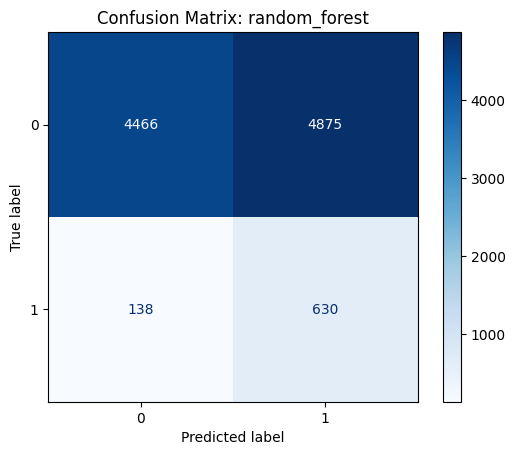

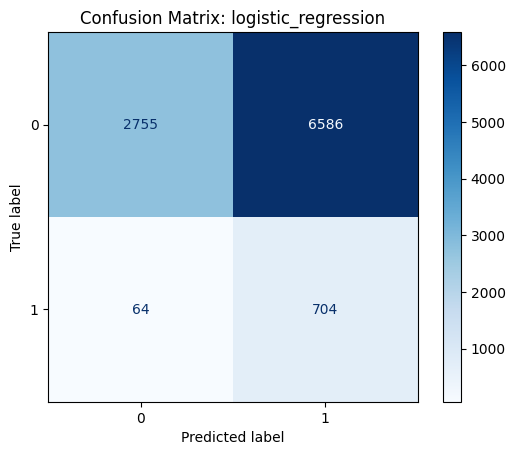

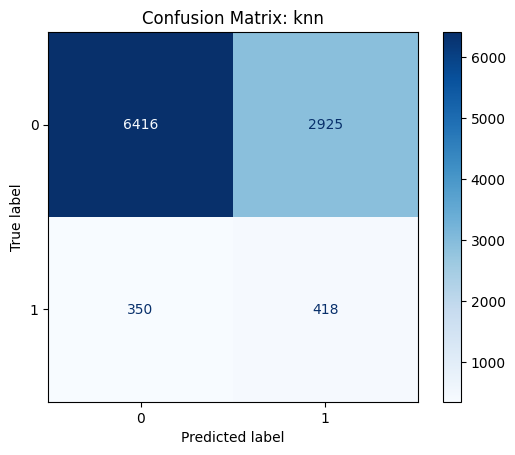

In [33]:
# Display the confusion matrix for each algorithm on the test set.
# A confusion matrix shows true positives, true negatives, false positives, and false negatives.
print("\n=== Confusion Matrices for Test Set ===")
for model_name, gs_object in algorithms.items():
    # Get the final refitted model.
    final_model = gs_object.best_estimator_
    # Make predictions on the original (but preprocessed) X_test.
    y_pred_test_cm = final_model.predict(X_test)
    
    # Plot the confusion matrix.
    # `plt.cm.Blues` is a colormap.
    fig, ax = plt.subplots() # Create figure and axes for better control if needed
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_cm, labels=[0,1], colorbar=True, cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f"Confusion Matrix: {model_name}")
    plt.show()